In [191]:
#tensorflow:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
#standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#own libs
import utils
from model import MODEL

In [331]:
#GLOBAL VARIABLES:
USE_PCT_CHANGE = False
ONLY_USE_MACD = True
USE_MACD = True
#STYLE = "daily"
STYLE = "hourly"

TICKERS = ["BTC-USD"]
#cols_available = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
COLS = ["Close"]
SEQUENCE_LENGTH = 12

In [332]:
#functions:
def to_sequence_target(data, seq_size, target="Close", target_index=0):
    input_dims = data.shape
    n_series = int(input_dims[0] / seq_size)
    x = np.empty((n_series, seq_size, input_dims[1]))
    y = np.empty((n_series, 1))
    for i in range(n_series):
        try:
            x[i] = data.values[i:i+seq_size]
            y[i] = data[target].values[i+seq_size+1]
        except AttributeError:
            x[i] = data[i:i+seq_size, :]
            y[i] = data[i+seq_size+1, target_index]
        
    print("Created X array with shape: {}".format(x.shape))
    print("Created Y array with shape: {}".format(y.shape))
    return x, y 

def to_sequence(data, seq_size):
    input_dims = data.shape
    n_series = int(input_dims[0] / seq_size)
    x = np.empty((n_series, seq_size, input_dims[1]))
    y = np.empty((n_series, input_dims[1]))
    for i in range(n_series):
        try:
            x[i] = data.values[i:i+seq_size]
            y[i] = data.values[i+seq_size+1]
        except AttributeError:
            x[i] = data[i:i+seq_size]
            y[i] = data[i+seq_size+1]
            
    print("Created X array with shape: {}".format(x.shape))
    print("Created Y array with shape: {}".format(y.shape))
    return x, y 

In [333]:
if STYLE == "daily":
    interval = "1d"
    start_date = None
elif STYLE == "hourly":
    interval = "60m"
    start_date = pd.to_datetime("today") - pd.Timedelta("729d")
data = utils.download_data(tickers=TICKERS, start=start_date, interval=interval, value=None)
data = data[COLS]
if USE_MACD:
    #insert macd analysis here:
    macd_model = MODEL(tickers=TICKERS)
    macd_model.get_data(start=start_date, interval=interval)
    macd_model.eval_model()
    data["MACD_GRAD"] = macd_model.grad[TICKERS[0]]
#drop some useless rows:
try:
    data = data[data["Volume"] != 0]
except KeyError:
    pass
if USE_PCT_CHANGE:
    data = data.pct_change()
    data.dropna(inplace=True)
if ONLY_USE_MACD:
    data = data["MACD_GRAD"]
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
|                                 PRICE MODEL                                  |
|                                 Version 1.0                                  |
|                 Authors: Patrick Lorenz &  Marco Rosenzweig                  |
--------------------------------------------------------------------------------
|                             ticker = ['BTC-USD']                             |
|                            start date = 10/01/18                             |
|                             end date = 09/29/20                              |
|                     initial investment per ticker = 200                      |
[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
********************************************************************************
[TICKER]: BTC-USD
[INFO]: No tax paid.
--

Datetime
2018-10-01 14:00:00+01:00   -0.017855
2018-10-01 15:00:00+01:00   -0.078491
2018-10-01 16:00:00+01:00    0.545919
2018-10-01 17:00:00+01:00    1.019305
2018-10-01 18:00:00+01:00    0.777386
                               ...   
2020-09-29 11:00:00+01:00    4.577380
2020-09-29 12:00:00+01:00    2.517733
2020-09-29 13:00:00+01:00    0.925631
2020-09-29 14:00:00+01:00    0.286805
2020-09-29 14:34:30+01:00    0.220639
Name: MACD_GRAD, Length: 17392, dtype: float64

In [334]:
data_train = data[data.index <= "2020-05"]
data_test = data[data.index > "2020-05"]
#check shapes:
if isinstance(data_train, pd.Series):
    data_train = np.expand_dims(data_train, -1)
if isinstance(data_test, pd.Series):
    data_test = np.expand_dims(data_test, -1)
#scale data:
scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
#split data:
x_train, y_train = to_sequence(data_train, SEQUENCE_LENGTH)
x_test, y_test = to_sequence(data_test, SEQUENCE_LENGTH)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

Created X array with shape: (1147, 12, 1)
Created Y array with shape: (1147, 1)
Created X array with shape: (301, 12, 1)
Created Y array with shape: (301, 1)


In [338]:
activation_function = "relu" #"softsign" 
loss_function = "mse", #"sparse_categorical_crossentropy"
metrics = ["mean_squared_error"]
optimizer = Adam(lr=0.001, decay=1e-6)
USE_RECURRENCE = False
USE_DROPOUT = False
USE_HIDDEN_LAYERS = False

#init:
model = Sequential()
#first layer:
model.add(LSTM(units=SEQUENCE_LENGTH, 
               return_sequences=USE_RECURRENCE, 
               activation=activation_function, 
               input_shape = (x_train.shape[1], x_train.shape[2])))
if USE_DROPOUT:
    model.add(Dropout(0.2))

#hidden layers:
if USE_HIDDEN_LAYERS:
    model.add(LSTM(units=50, 
                   return_sequences=True, 
                   activation=activation_function))
    if USE_DROPOUT:
        model.add(Dropout(0.2))
    model.add(LSTM(units=50, 
                   return_sequences=True, 
                   activation=activation_function))
    if USE_DROPOUT:
        model.add(Dropout(0.2))

    model.add(LSTM(units=50, 
                   activation=activation_function))
    if USE_DROPOUT:
        model.add(Dropout(0.2))
#final layer:
if USE_RECURRENCE and not USE_HIDDEN_LAYERS:
    #this must be included to get the right output dimension!
    model.add(LSTM(units=50, 
               activation=activation_function))
model.add(Dense(units=x_train.shape[2]))

model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
model.summary()
history = model.fit(x_train, y_train, batch_size=SEQUENCE_LENGTH, epochs=20)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_159 (LSTM)              (None, 12)                672       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
96/96 [==============================] - 1s 6ms/step - loss: 0.0824 - mean_squared_error: 0.0824
Epoch 2/20
96/96 [==============================] - 1s 6ms/step - loss: 3.8447e-04 - mean_squared_error: 3.8447e-04
Epoch 3/20
96/96 [==============================] - 1s 6ms/step - loss: 3.7803e-04 - mean_squared_error: 3.7803e-04
Epoch 4/20
96/96 [==============================] - 1s 6ms/step - loss: 3.8298e-04 - mean_squared_error: 3.8298e-04
Epoch 5/20
96/96 [==============================] - 1s 6ms/st

10/10 [==============================] - 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030    


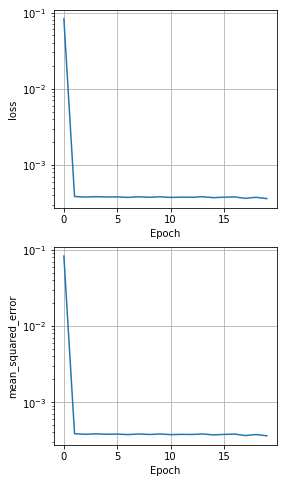

In [339]:
scores = model.evaluate(x_test, y_test)
keys = history.history.keys()
fig, ax = plt.subplots(nrows=len(keys), figsize=(4, 4*len(keys)))
for n, key in enumerate(keys):
    ax[n].semilogy(history.history[key])
    ax[n].set_xlabel("Epoch")
    ax[n].set_ylabel(key)
    ax[n].grid()

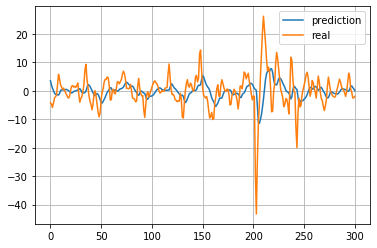

In [340]:
predicted = scaler.inverse_transform(model.predict(x_test))
real = scaler.inverse_transform(y_test)
try:
    labels = data.columns
    for i, label in enumerate(labels):
        if label == "Volume":
            continue
        plt.plot(predicted[:, i], label=label)
        plt.plot(real[:, i], label=labels[i] + " real", ls="--")
except AttributeError:
    plt.plot(predicted, label="prediction")
    plt.plot(real, label="real")
plt.grid()
plt.legend()
plt.show()